# Table 1. Thalamus + Zona Incerta subset of the CCN20230722 whole mouse brain taxonomy.

In [29]:
import pandas as pd

from IPython.display import display, HTML

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline') 

## Load .obs data

In [2]:
# define path for saving outputs
results_dir = '../../results'

In [3]:
# load in the full dataset with the taxonomy color metadata
obs_wmb = abc.get_combined_metadata(drop_unused=False)

# load the thalamus subset
obs_th = abc.load_standard_thalamus(data_structure='obs')

# join the color metadata to the thalamus subset
color_cols = ['neurotransmitter_color', 
              'class_color', 
              'subclass_color', 
              'supertype_color', 
              'cluster_color']
obs_th_color = obs_th.join(obs_wmb[color_cols])

## Convert .obs dataframe to taxonomy table

In [4]:
# subset df to just taxonomy (+color) columns
taxonomy_levels = ['neurotransmitter','class', 'subclass', 'supertype', 'cluster']
obs_tax = obs_th_color.drop_duplicates(subset='cluster')[taxonomy_levels+color_cols]

# count the number of cells per unique cluster & add as column to the taxonomy df
cells_per_cluster_counts = obs_th_color.groupby('cluster',observed=True).size().reset_index(name='num_cells_in_cluster')
obs_tax = obs_tax.merge(cells_per_cluster_counts, on='cluster')

# clean up the taxonomy columns for sorting
for col in taxonomy_levels:
    # only keep categories that are present in the TH+ZI dataset
    obs_tax.loc[:,col] = obs_tax.loc[:,col].cat.remove_unused_categories()
    # remove leading/trailing whitespace
    obs_tax.loc[:,col] = obs_tax.loc[:,col].str.strip()
    # extract the ID # b/c lexically sorting the str object doesn't yield correct order
    obs_tax.loc[:,col+'_id'] = obs_tax.loc[:,col].str.extract('(\d+)', expand=False).astype(float)

# sort by ID #s
num_cols = [x+'_id' for x in taxonomy_levels]
taxonomy_df = obs_tax.sort_values(by=num_cols, ascending=True, ignore_index=True)
# clean up the ID columns
taxonomy_df = taxonomy_df.drop(columns=num_cols)

display(taxonomy_df.head(5))

,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,num_cells_in_cluster
0,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#CC807A,71
1,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#FFBB73,128
2,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#66483D,179
3,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#81CC3D,78
4,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1584 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#8FFF26,47


In [5]:
tax_result = taxonomy_df.groupby('subclass')['supertype'].nunique().reset_index()
tax_result.columns = ['subclass', 'unique_supertype_count']
tax_result

,subclass,unique_supertype_count
0,102 DMH-LHA Gsx1 Gaba,3
1,156 MB-ant-ve Dmrta2 Glut,1
2,160 PAG-SC Neurod2 Meis2 Glut,1
3,164 APN C1ql4 Glut,1
4,168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut,12
5,176 SCig Foxb1 Glut,1
6,177 SCig-an-PPT Foxb1 Glut,1
7,197 SNr Six3 Gaba,1
8,159 IF-RL-CLI-PAG Foxa1 Glut,2
9,101 ZI Pax6 Gaba,11


In [6]:
# Save out as csv file
taxonomy_df.to_csv(f'{results_dir}/thalamus_zi_taxonomy_CCN20230722.csv', index=False)

## Format taxonomy df as HTML table with colored markers

In [7]:
def create_abc_atlas_html_table(df):
    ''' Create an HTML table with the same custom formatting & dynamic color
    markers as the ABC Atlas taxonomy resource html page.
    
    See: https://alleninstitute.github.io/abc_atlas_access/_static/WMB-taxonomy/20230830/cluster.html#CS20230722_CLUS_0001
    '''
    # define the CSS style used by the ABC Atlas resource page
    # includes alternating gray and white with on-hover color
    styles = """
    <style>
    .mystyle {
        font-size: 11pt; 
        font-family: Arial;
        border-collapse: collapse; 
        border: 1px solid silver;
    }
    .mystyle td {
        padding: 5px;
    }
    .mystyle th {
        text-align: left;
        padding: 5px;
    }
    .mystyle tr:nth-child(even) {
        background: #E0E0E0;
    }
    .circle {
        background-color: blue;
        height: 20px;
        width: 20px;
        border-radius: 50%;
        display: inline-block;
    }
    .celltext {
        padding-left: 5px;
        display: inline-block;
    }
    </style>
    """
    
    def format_cell(value, color):
        ''' Set the circle color and text value for each cell using the defined 
        ABC Atlas taxonomy style.
        '''
        return f'<span class="circle" style="background-color: {color};"></span><span class="celltext">{value}</span>'

    # apply custom HTML formatting to each cell in the df
    formatted_df = pd.DataFrame()
    for col in df.columns:
        if not col.endswith('_color'):
            color_col = f'{col}_color'
            # add colored circle to each column that has a corresponding color column
            if color_col in df.columns:
                formatted_df[col] = df.apply(lambda x: format_cell(x[col], x[color_col]), axis=1)
            # otherwise, just the cell value as text
            else:
                formatted_df[col] = df[col]

    # convert df to html table via pandas
    html_table = formatted_df.to_html(escape=False, classes='mystyle')

    # append style to top of HTML table so it's stored with the html file
    # (alternatively, could be saved to a separate .css file and linked to the html file)
    full_html = styles + html_table
    return full_html

In [8]:
# convert taxonomy df to a HTML table formatted the same as the ABC Atlas resource
html_table = create_abc_atlas_html_table(taxonomy_df)

# save as html file to results
with open(f'{results_dir}/thalamus_zi_taxonomy_CCN20230722_table.html', 'w') as f:
    f.write(html_table)

## Display full taxonomy table in HTML format

In [9]:
# show the HTML table inline
display(HTML(html_table))

,neurotransmitter,class,subclass,supertype,cluster,num_cells_in_cluster
0,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1,71
1,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1,128
2,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1,179
3,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1,78
4,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1584 RT-ZI Gnb3 Gaba_1,47
5,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1585 RT-ZI Gnb3 Gaba_1,42
6,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1586 RT-ZI Gnb3 Gaba_2,104
7,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1587 RT-ZI Gnb3 Gaba_2,49
8,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1588 RT-ZI Gnb3 Gaba_2,238
9,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1589 RT-ZI Gnb3 Gaba_2,20


In [10]:
taxonomy_df_fig1 = taxonomy_df[taxonomy_df['num_cells_in_cluster']>=50].copy()

for col in taxonomy_levels:
    # only keep categories that are present in this subset of the data
    taxonomy_df_fig1.loc[:,col] = taxonomy_df_fig1.loc[:,col].cat.remove_unused_categories()
    
taxonomy_df_fig1

,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,num_cells_in_cluster
0,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#CC807A,71
1,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#FFBB73,128
2,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#66483D,179
3,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#81CC3D,78
6,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1586 RT-ZI Gnb3 Gaba_2,#FF3358,#FF6600,#CCB65C,#93FF4D,#663E1F,104
...,...,...,...,...,...,...,...,...,...,...,...
542,GABA,20 MB GABA,203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba,0839 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_6,3663 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_6,#FF3358,#9EF01A,#FFC199,#2A9900,#991741,70
545,GABA,20 MB GABA,203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba,0839 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_6,3666 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_6,#FF3358,#9EF01A,#FFC199,#2A9900,#FF4DFD,70
547,GABA,20 MB GABA,203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba,0840 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_7,3668 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_7,#FF3358,#9EF01A,#FFC199,#66004A,#00CC2C,70
554,GABA,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3798 SCsg Gabrr2 Gaba_1,#FF3358,#9EF01A,#0e0163,#99456C,#AE26FF,81


In [11]:
display(list(taxonomy_df_fig1['subclass'].unique()))
taxonomy_df_fig1['subclass'].unique()

['093 RT-ZI Gnb3 Gaba',
 '101 ZI Pax6 Gaba',
 '109 LGv-ZI Otx2 Gaba',
 '145 MH Tac2 Glut',
 '146 LH Pou4f1 Sox1 Glut',
 '147 AD Serpinb7 Glut',
 '148 AV Col27a1 Glut',
 '149 PVT-PT Ntrk1 Glut',
 '150 CM-IAD-CL-PCN Sema5b Glut',
 '151 TH Prkcd Grin2c Glut',
 '152 RE-Xi Nox4 Glut',
 '153 MG-POL-SGN Nts Glut',
 '154 PF Fzd5 Glut',
 '156 MB-ant-ve Dmrta2 Glut',
 '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut',
 '197 SNr Six3 Gaba',
 '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
 '213 SCsg Gabrr2 Gaba']

['093 RT-ZI Gnb3 Gaba', '101 ZI Pax6 Gaba', '109 LGv-ZI Otx2 Gaba', '145 MH Tac2 Glut', '146 LH Pou4f1 Sox1 Glut', ..., '156 MB-ant-ve Dmrta2 Glut', '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '197 SNr Six3 Gaba', '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba', '213 SCsg Gabrr2 Gaba']
Length: 18
Categories (18, object): ['156 MB-ant-ve Dmrta2 Glut', '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '197 SNr Six3 Gaba', '101 ZI Pax6 Gaba', ..., '147 AD Serpinb7 Glut', '153 MG-POL-SGN Nts Glut', '150 CM-IAD-CL-PCN Sema5b Glut', '145 MH Tac2 Glut']

In [12]:
result = taxonomy_df_fig1.groupby('subclass')['supertype'].nunique().reset_index()
result.columns = ['subclass', 'unique_supertype_count']
result

,subclass,unique_supertype_count
0,156 MB-ant-ve Dmrta2 Glut,1
1,168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut,7
2,197 SNr Six3 Gaba,1
3,101 ZI Pax6 Gaba,8
4,109 LGv-ZI Otx2 Gaba,2
5,093 RT-ZI Gnb3 Gaba,5
6,149 PVT-PT Ntrk1 Glut,6
7,151 TH Prkcd Grin2c Glut,14
8,152 RE-Xi Nox4 Glut,3
9,154 PF Fzd5 Glut,2


In [13]:
fig1_subclasses = list(taxonomy_df_fig1['subclass'].unique())
fig1_subclasses

['093 RT-ZI Gnb3 Gaba',
 '101 ZI Pax6 Gaba',
 '109 LGv-ZI Otx2 Gaba',
 '145 MH Tac2 Glut',
 '146 LH Pou4f1 Sox1 Glut',
 '147 AD Serpinb7 Glut',
 '148 AV Col27a1 Glut',
 '149 PVT-PT Ntrk1 Glut',
 '150 CM-IAD-CL-PCN Sema5b Glut',
 '151 TH Prkcd Grin2c Glut',
 '152 RE-Xi Nox4 Glut',
 '153 MG-POL-SGN Nts Glut',
 '154 PF Fzd5 Glut',
 '156 MB-ant-ve Dmrta2 Glut',
 '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut',
 '197 SNr Six3 Gaba',
 '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
 '213 SCsg Gabrr2 Gaba']

In [14]:
taxonomy_df_fig1_subclasses = taxonomy_df[taxonomy_df['subclass'].isin(fig1_subclasses)].copy()

for col in taxonomy_levels:
    # only keep categories that are present in this subset of the data
    taxonomy_df_fig1_subclasses.loc[:,col] = taxonomy_df_fig1_subclasses.loc[:,col].cat.remove_unused_categories()

In [34]:
taxonomy_df_fig1_subclasses.head(20)

,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,num_cells_in_cluster
0,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#CC807A,71
1,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#FFBB73,128
2,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#66483D,179
3,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#81CC3D,78
4,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1584 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#8FFF26,47
5,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1585 RT-ZI Gnb3 Gaba_1,#FF3358,#FF6600,#CCB65C,#99FFFC,#FF7388,42
6,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1586 RT-ZI Gnb3 Gaba_2,#FF3358,#FF6600,#CCB65C,#93FF4D,#663E1F,104
7,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1587 RT-ZI Gnb3 Gaba_2,#FF3358,#FF6600,#CCB65C,#93FF4D,#0F2A66,49
8,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1588 RT-ZI Gnb3 Gaba_2,#FF3358,#FF6600,#CCB65C,#93FF4D,#CC5C83,238
9,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0432 RT-ZI Gnb3 Gaba_2,1589 RT-ZI Gnb3 Gaba_2,#FF3358,#FF6600,#CCB65C,#93FF4D,#3D6663,20


In [36]:
dict(zip(taxonomy_df_fig1_subclasses['supertype'], taxonomy_df_fig1_subclasses['supertype_color']))

{'0431 RT-ZI Gnb3 Gaba_1': '#99FFFC',
 '0432 RT-ZI Gnb3 Gaba_2': '#93FF4D',
 '0433 RT-ZI Gnb3 Gaba_3': '#29CC1F',
 '0434 RT-ZI Gnb3 Gaba_4': '#179930',
 '0435 RT-ZI Gnb3 Gaba_5': '#90995C',
 '0459 ZI Pax6 Gaba_1': '#1F1799',
 '0460 ZI Pax6 Gaba_2': '#CC7A86',
 '0461 ZI Pax6 Gaba_3': '#CC5A3D',
 '0462 ZI Pax6 Gaba_4': '#52660F',
 '0463 ZI Pax6 Gaba_5': '#73FF9B',
 '0464 ZI Pax6 Gaba_6': '#00FF1D',
 '0465 ZI Pax6 Gaba_7': '#453DCC',
 '0466 ZI Pax6 Gaba_8': '#299917',
 '0467 ZI Pax6 Gaba_9': '#99457F',
 '0468 ZI Pax6 Gaba_10': '#4A1FCC',
 '0469 ZI Pax6 Gaba_11': '#FFAF99',
 '0496 LGv-ZI Otx2 Gaba_1': '#AF7ACC',
 '0497 LGv-ZI Otx2 Gaba_2': '#66453D',
 '0498 LGv-ZI Otx2 Gaba_3': '#997F45',
 '0499 LGv-ZI Otx2 Gaba_4': '#5C9199',
 '0500 LGv-ZI Otx2 Gaba_5': '#5C6299',
 '0632 MH Tac2 Glut_1': '#701FCC',
 '0633 MH Tac2 Glut_2': '#661F30',
 '0634 MH Tac2 Glut_3': '#1700FF',
 '0635 MH Tac2 Glut_4': '#C8FF99',
 '0636 MH Tac2 Glut_5': '#FF0096',
 '0637 LH Pou4f1 Sox1 Glut_1': '#CC7AA1',
 '0638 LH P

In [16]:
list(taxonomy_df_fig1_subclasses['supertype'].unique())

['0431 RT-ZI Gnb3 Gaba_1',
 '0432 RT-ZI Gnb3 Gaba_2',
 '0433 RT-ZI Gnb3 Gaba_3',
 '0434 RT-ZI Gnb3 Gaba_4',
 '0435 RT-ZI Gnb3 Gaba_5',
 '0459 ZI Pax6 Gaba_1',
 '0460 ZI Pax6 Gaba_2',
 '0461 ZI Pax6 Gaba_3',
 '0462 ZI Pax6 Gaba_4',
 '0463 ZI Pax6 Gaba_5',
 '0464 ZI Pax6 Gaba_6',
 '0465 ZI Pax6 Gaba_7',
 '0466 ZI Pax6 Gaba_8',
 '0467 ZI Pax6 Gaba_9',
 '0468 ZI Pax6 Gaba_10',
 '0469 ZI Pax6 Gaba_11',
 '0496 LGv-ZI Otx2 Gaba_1',
 '0497 LGv-ZI Otx2 Gaba_2',
 '0498 LGv-ZI Otx2 Gaba_3',
 '0499 LGv-ZI Otx2 Gaba_4',
 '0500 LGv-ZI Otx2 Gaba_5',
 '0632 MH Tac2 Glut_1',
 '0633 MH Tac2 Glut_2',
 '0634 MH Tac2 Glut_3',
 '0635 MH Tac2 Glut_4',
 '0636 MH Tac2 Glut_5',
 '0637 LH Pou4f1 Sox1 Glut_1',
 '0638 LH Pou4f1 Sox1 Glut_2',
 '0639 LH Pou4f1 Sox1 Glut_3',
 '0640 LH Pou4f1 Sox1 Glut_4',
 '0641 AD Serpinb7 Glut_1',
 '0642 AV Col27a1 Glut_1',
 '0643 PVT-PT Ntrk1 Glut_1',
 '0644 PVT-PT Ntrk1 Glut_2',
 '0645 PVT-PT Ntrk1 Glut_3',
 '0646 PVT-PT Ntrk1 Glut_4',
 '0647 PVT-PT Ntrk1 Glut_5',
 '0648 PVT-PT N

In [17]:
unique_cluster_df = taxonomy_df_fig1_subclasses.groupby('supertype')['cluster'].nunique().reset_index()
unique_cluster_df.columns = ['supertype', 'unique_cluster_count']
unique_cluster_df

,supertype,unique_cluster_count
0,0681 MB-ant-ve Dmrta2 Glut_1,4
1,0729 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut_12,3
2,0806 SNr Six3 Gaba_1,1
3,0461 ZI Pax6 Gaba_3,9
4,0464 ZI Pax6 Gaba_6,6
...,...,...
83,0636 MH Tac2 Glut_5,3
84,0727 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut_10,2
85,0640 LH Pou4f1 Sox1 Glut_4,4
86,0635 MH Tac2 Glut_4,2


In [18]:
supertype_order = list(taxonomy_df_fig1_subclasses['supertype'].unique())
unique_cluster_df['supertype'] = pd.Categorical(unique_cluster_df['supertype'], 
                                                categories=supertype_order, 
                                                ordered=True)
unique_cluster_df = unique_cluster_df.sort_values('supertype').reset_index(drop=True)
unique_cluster_df

,supertype,unique_cluster_count
0,0431 RT-ZI Gnb3 Gaba_1,6
1,0432 RT-ZI Gnb3 Gaba_2,5
2,0433 RT-ZI Gnb3 Gaba_3,4
3,0434 RT-ZI Gnb3 Gaba_4,5
4,0435 RT-ZI Gnb3 Gaba_5,5
...,...,...
83,0838 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_5,5
84,0839 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_6,4
85,0840 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba_7,2
86,0872 SCsg Gabrr2 Gaba_1,8


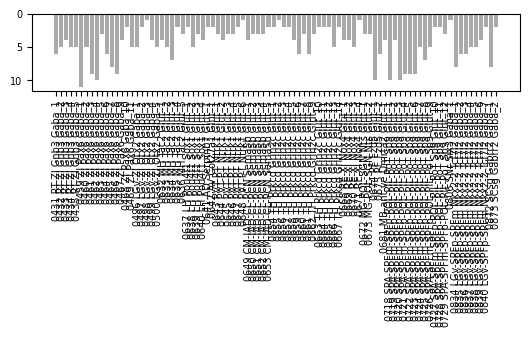

In [31]:
# sns.barplot(x='supertype', y='unique_cluster_count', data=unique_cluster_df, order=supertype_order)
fig, ax = plt.subplots(figsize=(6.3, 1))
plt.bar(unique_cluster_df['supertype'], 
        unique_cluster_df['unique_cluster_count'], 
        color='darkgrey')
# plt.xlabel('col1')
# plt.ylabel('Unique col2 Count')
# plt.title('Unique col2 Count per col1 Category')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
ax.invert_yaxis()

fig.savefig(f'{results_dir}/fig1A_cluster_count_hist.pdf',
            transparent=True, bbox_inches='tight')